<a href="https://colab.research.google.com/github/KatyaZeross/Capstone-Project---BrainStation/blob/main/Part_2_StarTrek_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project: Star Trek IMDB Ratings Predictor - Katya Kogan
--- 
## Part 2

Now we've successfully cleaned and prepared our data, we can begin our modelling process to determine if the characters (by their spoken parts) contribute to the `imdbRating`. 

Since we are focusing on feature importance, our models will have to be carefully chosen. (INSERT MORE INFO HERE AFTER MODELLING)
- Logistic Regression
- KNN
- Random Forest
- AdaBoost
- Gradient Boost Tree 

We'll begin by importing all the relevant libraries needed for our project. 


In [1]:
# import the relevant libraries needed 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# Ml libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

Now we've imported our libraries relevant to our needs, we'll begin by importing our dataset, some minor EDA and prep before getting into the nitty gritty for our models. 

Let's take a look. 

In [2]:
# uploading files into colab
from google.colab import files
uploaded = files.upload()

Saving StarTrek_Prepped.csv to StarTrek_Prepped (1).csv


In [3]:
# reading in the dataframe 
import io
ST_df = pd.read_csv(io.BytesIO(uploaded['StarTrek_Prepped.csv']))

In [4]:
# sanity check
ST_df.head()

,Unnamed: 0,EPISODE,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,TOTAL_WORDS,SCRIPT,RATING
0,0,11001001,38.84,36.79,11.73,2.05,0.00,5.16,5.43,0.0,0.0,2634.0,captains log stardate 9 the enterprise has be...,8
1,1,a fistful of datas,12.89,3.38,16.98,28.58,16.79,4.76,16.64,0.0,0.0,2103.0,captains log stardate the enterprise has ent...,8
2,2,a matter of honor,31.03,49.78,9.18,10.01,0.00,0.00,0.00,0.0,0.0,2037.0,"we are approaching starbase onesevennine, ha...",8
3,3,a matter of perspective,40.31,26.84,10.69,1.68,3.44,1.03,16.00,0.0,0.0,2731.0,we have arrived at tanuga four captain the aw...,7
4,4,a matter of time,37.49,10.42,20.31,6.02,2.68,6.30,16.79,0.0,0.0,2841.0,captains log stardate the enterprise is on i...,7


Now we've successfully imported our dataframe, we can see that there is still some minor cleaning to do. We'll have to drop the `Unnamed: 0` column. 

In addition to that, we'll also be converting the `RATING` column into a binary classification later on as well. 

But first, drop the `Unnamed: 0` column. 

In [5]:
# dropping the Unnamed: 0 column
ST_df.drop(labels='Unnamed: 0', inplace=True, axis=1)

In [6]:
# sanity check
ST_df.head()

,EPISODE,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,TOTAL_WORDS,SCRIPT,RATING
0,11001001,38.84,36.79,11.73,2.05,0.00,5.16,5.43,0.0,0.0,2634.0,captains log stardate 9 the enterprise has be...,8
1,a fistful of datas,12.89,3.38,16.98,28.58,16.79,4.76,16.64,0.0,0.0,2103.0,captains log stardate the enterprise has ent...,8
2,a matter of honor,31.03,49.78,9.18,10.01,0.00,0.00,0.00,0.0,0.0,2037.0,"we are approaching starbase onesevennine, ha...",8
3,a matter of perspective,40.31,26.84,10.69,1.68,3.44,1.03,16.00,0.0,0.0,2731.0,we have arrived at tanuga four captain the aw...,7
4,a matter of time,37.49,10.42,20.31,6.02,2.68,6.30,16.79,0.0,0.0,2841.0,captains log stardate the enterprise is on i...,7


Great, we've successfully dropped the unnecessary column. Now, let's take a closer look at the `RATING` distribution. 

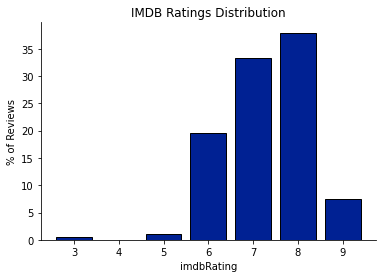

In [7]:
# looking at the distribution of the IMDB Ratings
values, counts = np.unique(ST_df['RATING'], return_counts=True)
normalized_reviews = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_reviews * 100, edgecolor='black', color='#002193')
plt.xlabel('imdbRating')
plt.ylabel('% of Reviews')
sns.despine()
plt.title("IMDB Ratings Distribution")
plt.savefig("IMDB Ratings Distribution")
plt.show()

We can see that the distribution is normal, with a slight skew to the left. More than 20% of the total reviews are above a rating of 7 or higher. This is great because the show wouldn't continue without having an average of solid ratings of 7 or more.  

Our next step is to convert the `RATING` into a boolean. In order to achieve a better balance between high and low ratings, this is achieved through: 
- Any score above a value of 8 will be assigned 1 (Good Ratings)
- Any score between 1-7 will be be assigned 0 (Bad Ratings)

Let's convert our `RATING` column to Boolean values. 



In [8]:
# convert the RATING column into binary values 
ST_df['RATING'] = np.where(ST_df['RATING'] >= 8, 1, 0)

In [9]:
#sanity check
ST_df.head()

,EPISODE,PICARD_PCT,RIKER_PCT,DATA_PCT,WORF_PCT,TROI_PCT,BEVERLY_PCT,GEORDI_PCT,Q_PCT,LORE_PCT,TOTAL_WORDS,SCRIPT,RATING
0,11001001,38.84,36.79,11.73,2.05,0.00,5.16,5.43,0.0,0.0,2634.0,captains log stardate 9 the enterprise has be...,1
1,a fistful of datas,12.89,3.38,16.98,28.58,16.79,4.76,16.64,0.0,0.0,2103.0,captains log stardate the enterprise has ent...,1
2,a matter of honor,31.03,49.78,9.18,10.01,0.00,0.00,0.00,0.0,0.0,2037.0,"we are approaching starbase onesevennine, ha...",1
3,a matter of perspective,40.31,26.84,10.69,1.68,3.44,1.03,16.00,0.0,0.0,2731.0,we have arrived at tanuga four captain the aw...,0
4,a matter of time,37.49,10.42,20.31,6.02,2.68,6.30,16.79,0.0,0.0,2841.0,captains log stardate the enterprise is on i...,0


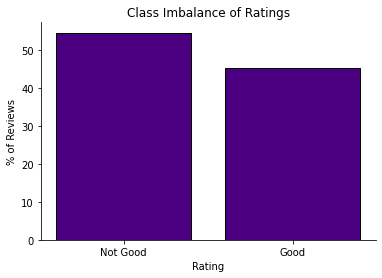

Class imbalance: [0.546 0.454]


In [10]:
# check target distribution in data

# count the unique values and the number of times they appear
values, counts = np.unique(ST_df['RATING'], return_counts=True)

# normalize the counts to bring them into the same range (o and 1)
normalized_counts = counts/counts.sum()

# instantiate the plot
plt.figure()

# create a bar plot and convert the normalized_counts to percentage 
plt.bar(["Not Good", "Good"], normalized_counts*100, edgecolor='black', color='indigo') 

# relevant labels
plt.xlabel('Rating')
plt.ylabel('% of Reviews')
plt.title('Class Imbalance of Ratings')
sns.despine()
plt.show()

# print the distribution of class imbalance
print(f"Class imbalance: {np.round(normalized_counts, 3)}")


The result is an imbalance of 55% to 45%, which is a great result to work with the majority of model types. Remember, the distribution of the score was normally distributed, and converting the `RATING` in this manner allows the data to be modelled, without having to modify anything.

Moving on, we can be confident going ahead with splitting the data set into train and test sets for our vectorization of the `RATING` column into numerical datatypes.

Before even attempting to vectorize the `RATING` column, we need to split the set into training and testing sets. After the splitting is completed, the training set(s) will be fit and transformed. Sidenote: the testing data shouldn't be mixed with the fit and transformation of the data. The fitting and transformation process will be applied separately to the `RATING` column.

Essentially:

1. Split `ST_df` into train and test sets
2. Apply `CountVectorizer()` on the training set for the `RATING` column
3. With the fitted `RATING`, transform the `RATING` column for both X_train and X_test
4. Save as a DataFrame
5. Combine the transformed `RATING` dataframe with the rest of the numeric columns of the training and test dataset

We'll begin by defining our X and y values:

X : all columns except for `RATING` (independent)
y : contains only `RATING` (dependent)